# **Install the repo and dependencies**

In [ ]:
!pip install 'git+https://github.com/facebookresearch/sam2.git'

  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-p_3qbdzr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-p_3qbdzr
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
 

In [ ]:
import torch
import torchvision
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import nibabel as nib
import subprocess
import cv2

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

# drive.mount('/content/drive')
checkpoint_path = "/content/drive/MyDrive/KiTS23_dataset/sam2.1_hiera_large.pt"

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Data**



We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

# **Video to Frames**

In [ ]:
def convert_vid_to_jpeg_opencv(video_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if no more frames

        frame_path = os.path.join(output_dir, f"{frame_count:05d}.jpg")
        cv2.imwrite(frame_path, frame)  # Save frame as JPEG
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {output_dir}")

# Example usage:
video_path = '/content/drive/MyDrive/KiTS23_dataset/case_00000_overlay_video.mp4'
video_dir = 'video_dir'
convert_vid_to_jpeg_opencv(video_path, video_dir)

Extracted 264 frames to video_dir


# **3D Scans to Frames**

In [ ]:
# ... (previous code) ...

def convert_nii_to_jpeg(nii_path, output_dir):
    # Load the NIfTI file
    nii = nib.load(nii_path)
    data = nii.get_fdata()

    # Normalize to 0-255 (Assuming the data is in Hounsfield units or similar range)
    data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255.0
    data = data.astype(np.uint8)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through slices and save as JPEGs
    for i in range(data.shape[2]):  # Assuming axial slices
        img = Image.fromarray(data[:, :, i])
        filename = os.path.join(output_dir, f"{i:05d}.jpg")
        img.save(filename, quality=95)  # High-quality JPEG

    print(f"Saved {data.shape[2]} frames in {output_dir}")

# Replace '/path/to/your/nifti_file.nii.gz' with the actual path to your NIfTI file
nifti_file_path = '/content/drive/MyDrive/KiTS23_dataset/case_00000/imaging.nii.gz'
convert_nii_to_jpeg(nifti_file_path, "output_frames")

# `video_dir` should be the directory containing the JPEG frames, not the path to a single JPEG file
video_dir = "video_dir"  # Changed from "/content/video_dir/00132.jpg"

Saved 512 frames in output_frames


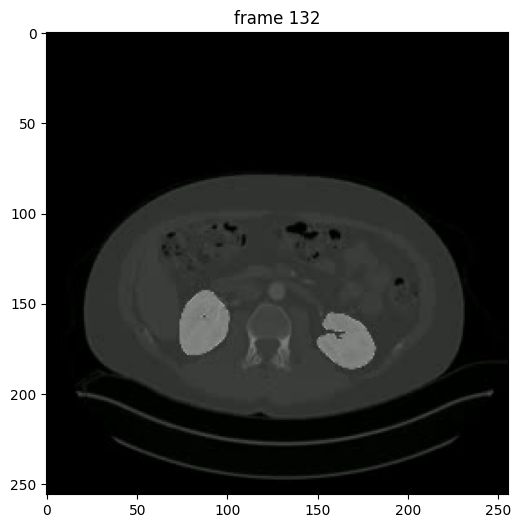

In [ ]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 132
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx]))) # Changed to use a frame from output_frames


# **Use Pre-Trained Model or to train model go downwards**

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


#### Loading the SAM 2 video predictor

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = checkpoint_path
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Initialize the inference state

In [ ]:

# Initialize the inference state with the correct directory
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 264/264 [00:07<00:00, 35.06it/s]


# **To segment & track one object**

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [ ]:
predictor.reset_state(inference_state)

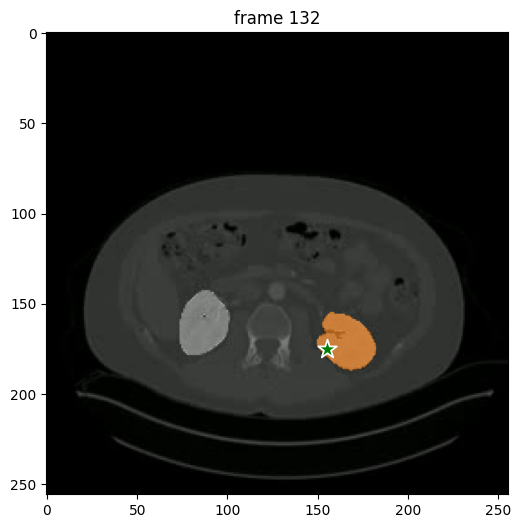

In [ ]:
ann_frame_idx = 132  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[155, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

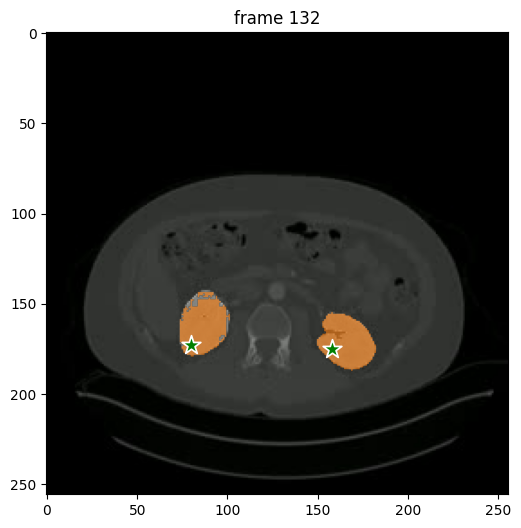

In [ ]:
ann_frame_idx = 132  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([], dtype=np.float32)
points = np.array([[158, 175], [80, 173]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video: 100%|██████████| 132/132 [02:18<00:00,  1.05s/it]


Skipping frame 0 as it has no segmentation data.
Skipping frame 30 as it has no segmentation data.
Skipping frame 60 as it has no segmentation data.
Skipping frame 90 as it has no segmentation data.
Skipping frame 120 as it has no segmentation data.


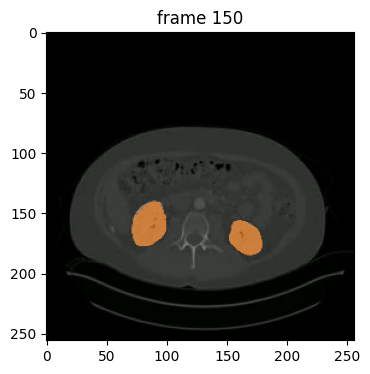

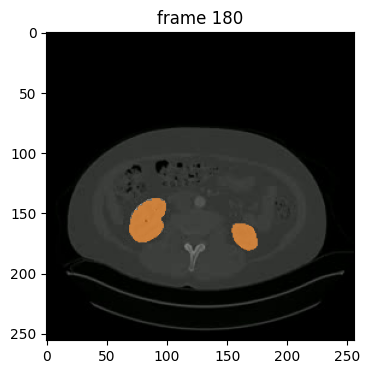

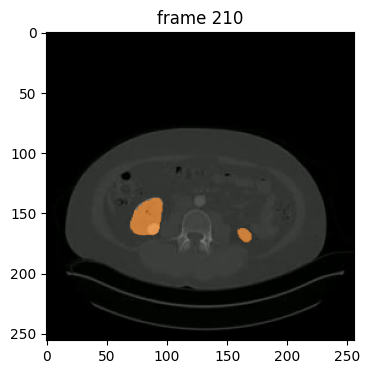

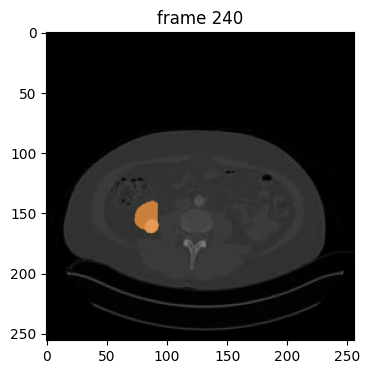

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Check if the frame has segmentation data
    if out_frame_idx in video_segments:
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    else:
        # If not, you might want to skip it or display a placeholder
        print(f"Skipping frame {out_frame_idx} as it has no segmentation data.")

It appears that in the output masklet above, there are some imperfections in boundary details on frame 90.

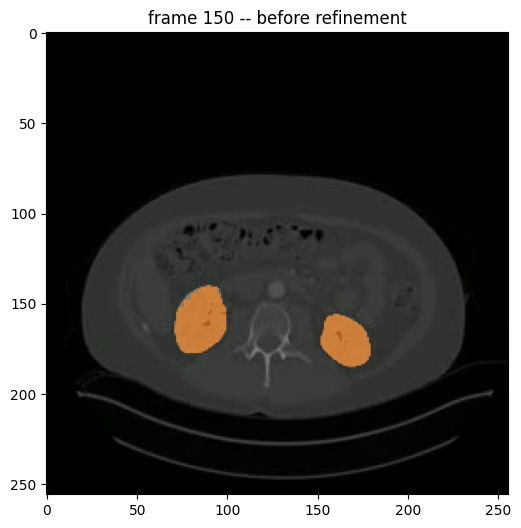

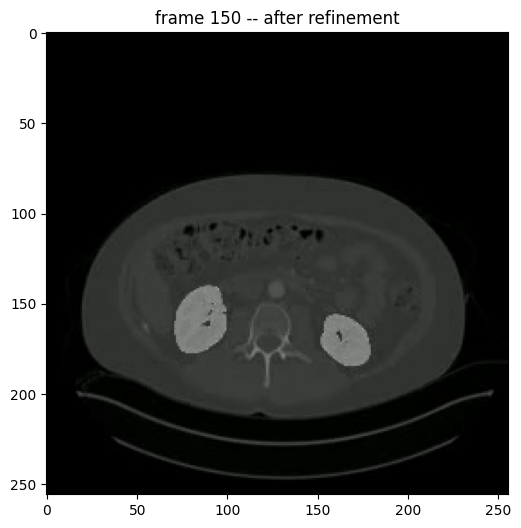

In [ ]:
ann_frame_idx = 150  # further refine some details on this frame
ann_obj_id = 1  # give a unique id to the object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a negative click on this frame at (x, y) = (82, 415) to refine the segment
points = np.array([[82, 410]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([0], np.int32)
_, _, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the segment after the further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- after refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

Let's get an updated masklet for the entire video. Here we call `propagate_in_video` again to propagate all the prompts after adding the new refinement click above.

propagate in video: 100%|██████████| 132/132 [02:21<00:00,  1.07s/it]


Skipping frame 0 as it has no segmentation data.
Skipping frame 30 as it has no segmentation data.
Skipping frame 60 as it has no segmentation data.
Skipping frame 90 as it has no segmentation data.
Skipping frame 120 as it has no segmentation data.


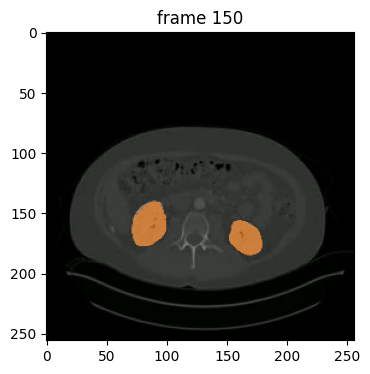

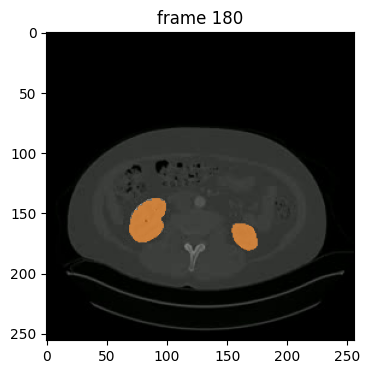

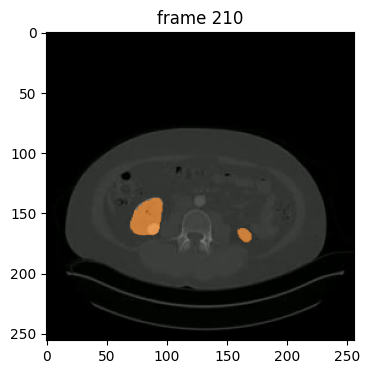

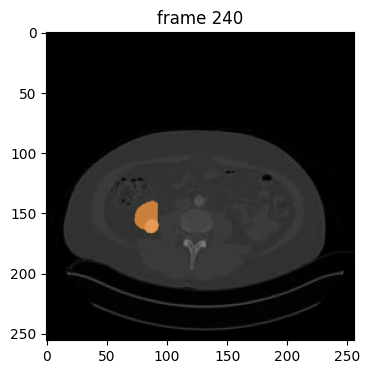

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Check if the frame has segmentation data
    if out_frame_idx in video_segments:
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    else:
        # If not, you might want to skip it or display a placeholder
        print(f"Skipping frame {out_frame_idx} as it has no segmentation data.")

The segments now look good on all frames.

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [ ]:
predictor.reset_state(inference_state)

In addition to using clicks as inputs, SAM 2 also supports segmenting and tracking objects in a video via **bounding boxes**.

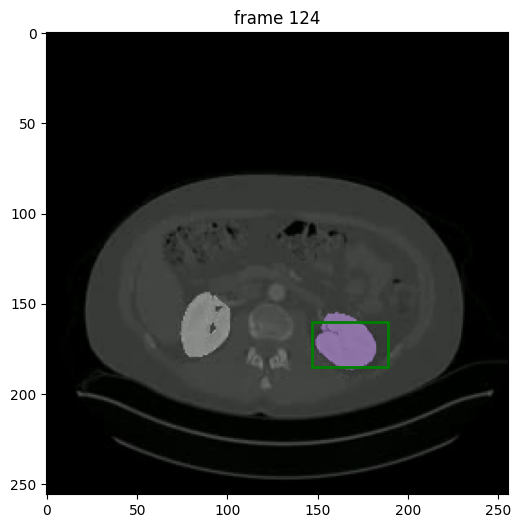

In [ ]:

ann_frame_idx = 124  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
box = np.array([147, 160, 189, 185], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

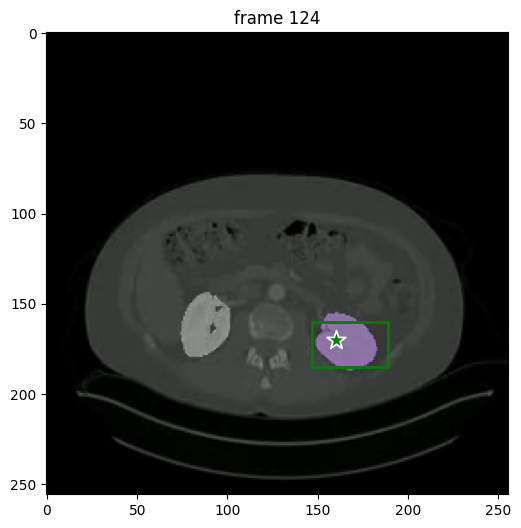

In [ ]:
ann_frame_idx = 124  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (460, 60) to refine the mask
points = np.array([[160, 170]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# note that we also need to send the original box input along with
# the new refinement click together into `add_new_points_or_box`
box = np.array([147, 160, 189, 185], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

Then, to get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video: 100%|██████████| 264/264 [05:04<00:00,  1.15s/it]


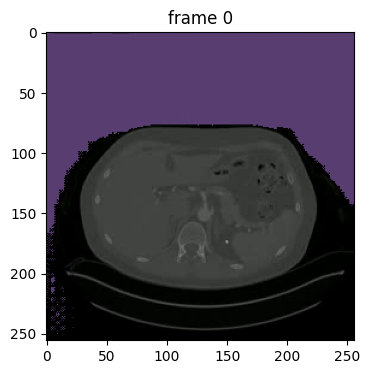

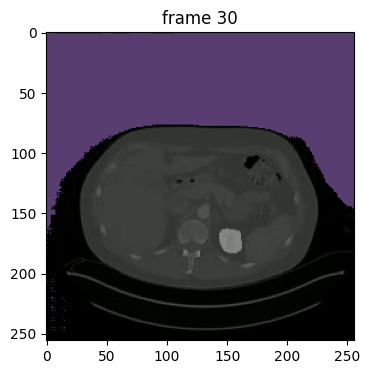

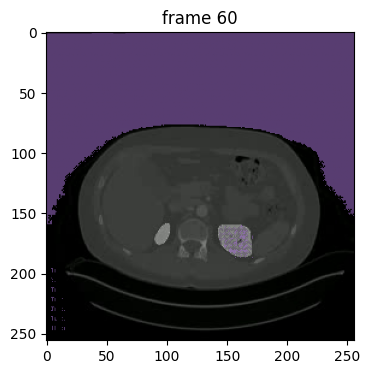

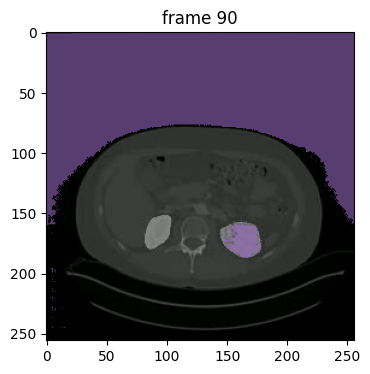

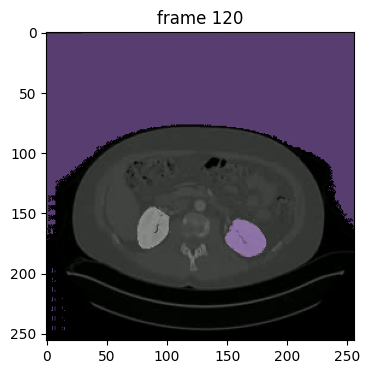

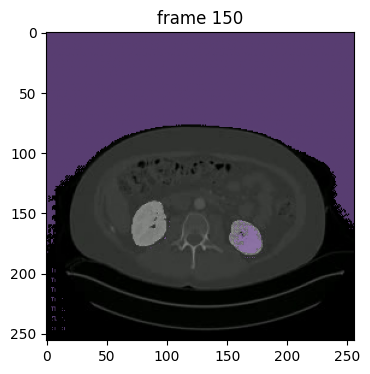

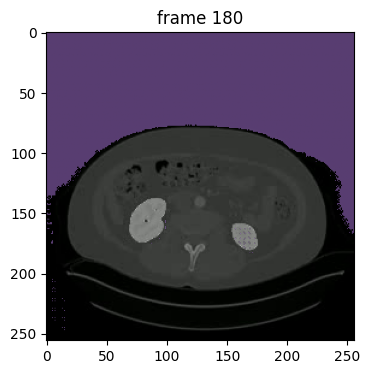

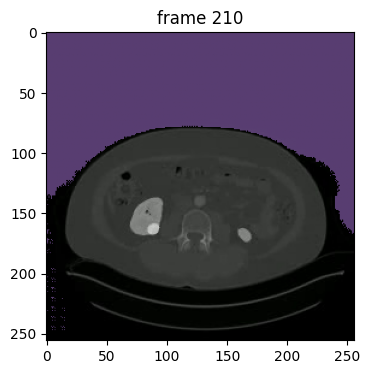

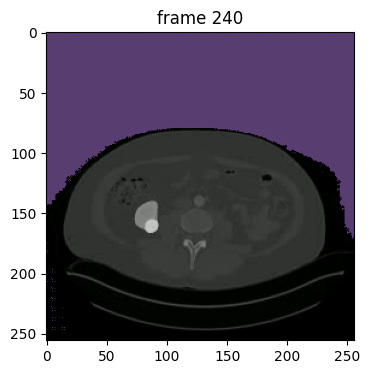

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Note that in addition to clicks or boxes, SAM 2 also supports directly using a **mask prompt** as input via the `add_new_mask` method in the `SAM2VideoPredictor` class. This can be helpful in e.g. semi-supervised VOS evaluations (see [tools/vos_inference.py](https://github.com/facebookresearch/sam2/blob/main/tools/vos_inference.py) for an example).

# **To segment & track Multiple objects**

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [ ]:
predictor.reset_state(inference_state)

SAM 2 can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

In [ ]:
prompts = {}  # hold all the clicks we add for visualization

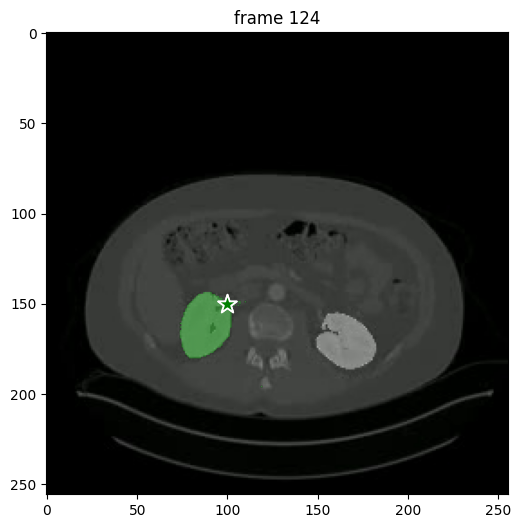

In [ ]:
ann_frame_idx = 124  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[100, 150]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

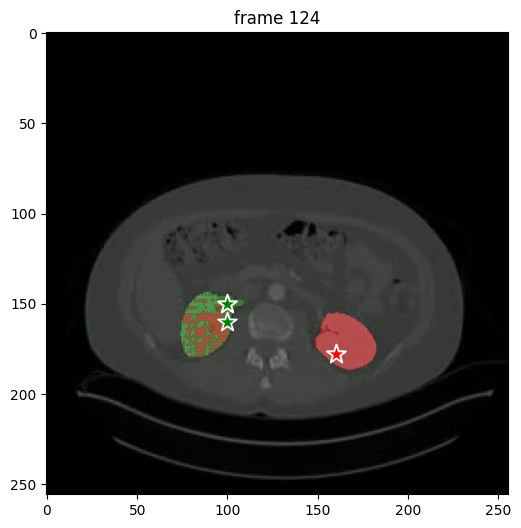

In [ ]:
# add the first object
ann_frame_idx = 124  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[100, 150], [160, 178]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

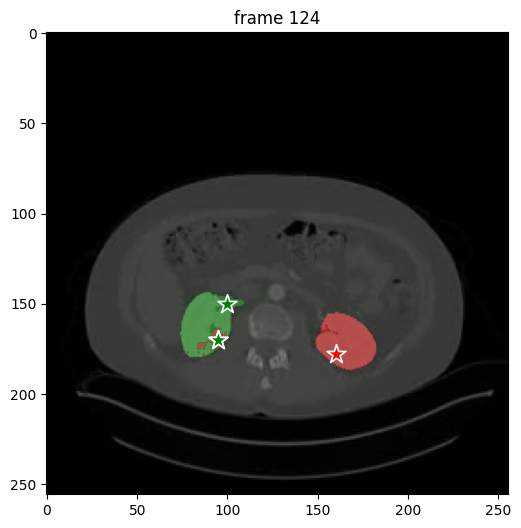

In [ ]:
ann_frame_idx = 124  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[95, 170]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

This time the model predicts the mask of the shirt we want to track in just one click. Nice!

#### Propagate the prompts to get masklets across the video

Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

propagate in video: 100%|██████████| 264/264 [06:02<00:00,  1.37s/it]


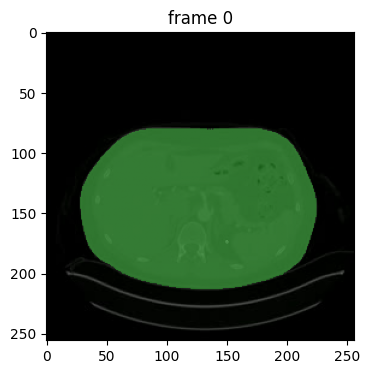

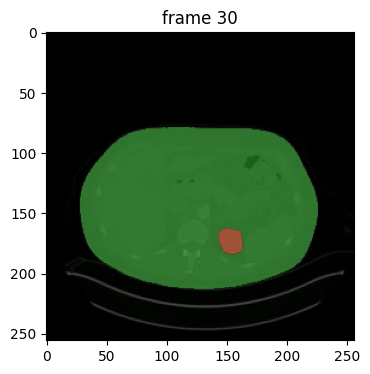

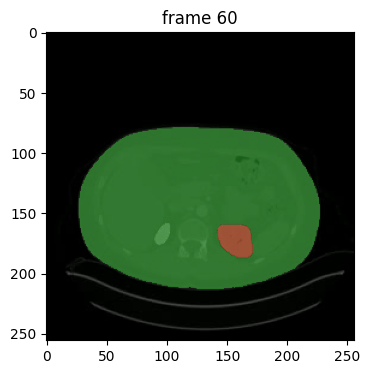

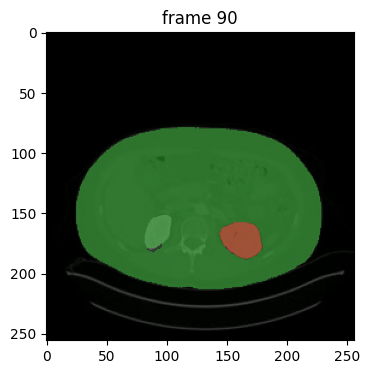

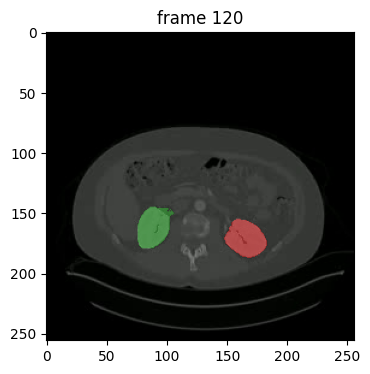

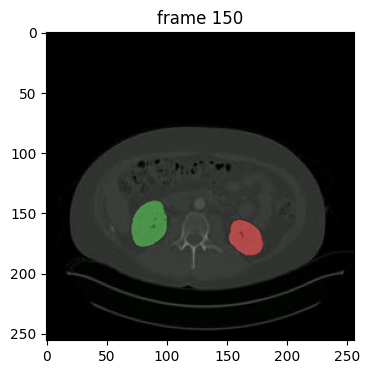

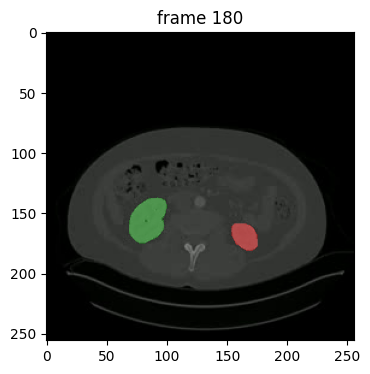

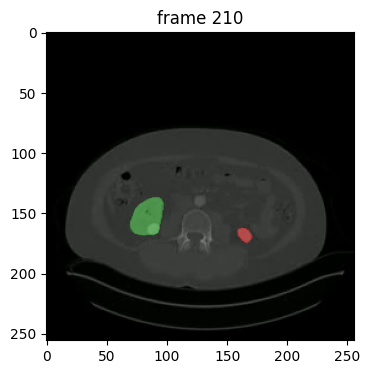

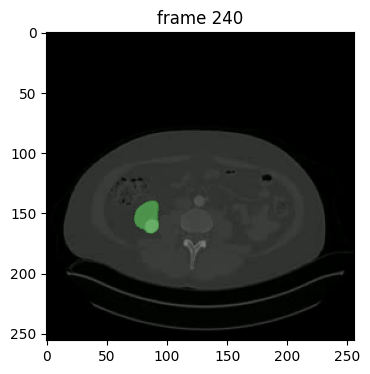

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

# **To Fine-tune the model**

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything-2
%cd segment-anything-2

  Cloning https://github.com/facebookresearch/segment-anything-2 to /tmp/pip-req-build-zmw2l_pm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2 /tmp/pip-req-build-zmw2l_pm
  Resolved https://github.com/facebookresearch/segment-anything-2 to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_

[Errno 2] No such file or directory: 'segment-anything-2'
/content


In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 # For different version

In [ ]:
!pip install --upgrade hydra-core omegaconf hydra-core timm

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
import nibabel as nib
import cv2
from skimage.io import imread
from sklearn.metrics import jaccard_score

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

# drive.mount('/content/drive')
checkpoint_path = "/content/drive/MyDrive/KiTS23_dataset/sam2.1_hiera_large.pt"


PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True


In [ ]:
!git clone https://github.com/neheller/kits23.git
%cd kits23/dataset

Cloning into 'kits23'...
remote: Enumerating objects: 15592, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 15592 (delta 30), reused 55 (delta 25), pack-reused 15526 (from 1)
Receiving objects: 100% (15592/15592), 493.93 MiB | 44.95 MiB/s, done.
Resolving deltas: 100% (13999/13999), done.
Updating files: 100% (5720/5720), done.
/content/segment-anything-2/kits23/dataset


In [ ]:
!unrar x /content/drive/MyDrive/splitdata.rar /content/dataset/

Streaming output truncated to the last 5000 lines.
Extracting  /content/dataset/splitdata/val/slices/22-slice289_x.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice291_y.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice294_x.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice294_y.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice296_y.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice296_z.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice299_z.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice300_x.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice300_y.png       87%  OK 
Extracting  /content/dataset/splitdata/val/slices/22-slice302_z.png       87%  OK 
Extracting  /content/dataset/

In [ ]:
!cat /content/drive/MyDrive/configs/sam2/sam2_hiera_l.yaml

# @package _global_

# Model
model:
  _target_: sam2.modeling.sam2_base.SAM2Base
  image_encoder:
    _target_: sam2.modeling.backbones.image_encoder.ImageEncoder
    scalp: 1
    trunk:
      _target_: sam2.modeling.backbones.hieradet.Hiera
      embed_dim: 144
      num_heads: 2
      stages: [2, 6, 36, 4]
      global_att_blocks: [23, 33, 43]
      window_pos_embed_bkg_spatial_size: [7, 7]
      window_spec: [8, 4, 16, 8]
    neck:
      _target_: sam2.modeling.backbones.image_encoder.FpnNeck
      position_encoding:
        _target_: sam2.modeling.position_encoding.PositionEmbeddingSine
        num_pos_feats: 256
        normalize: true
        scale: null
        temperature: 10000
      d_model: 256
      backbone_channel_list: [1152, 576, 288, 144]
      fpn_top_down_levels: [2, 3]  # output level 0 and 1 directly use the backbone features
      fpn_interp_model: nearest

  memory_attention:
    _target_: sam2.modeling.memory_attention.MemoryAttention
    d_model: 256
    pos_en

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Dataset Class
class KiTS23Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = imread(img_path)
        mask = imread(mask_path, as_gray=True)  # Binary mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Define Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((1024, 1024)),
])

# Paths
train_img_dir = "/content/dataset/splitdata/train/slices"
train_mask_dir = "/content/dataset/splitdata/train/masks"
val_img_dir = "/content/dataset/splitdata/val/slices"
val_mask_dir = "/content/dataset/splitdata/val/masks"

# Load Data
train_dataset = KiTS23Dataset(train_img_dir, train_mask_dir, transform)
val_dataset = KiTS23Dataset(val_img_dir, val_mask_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load SAM2 Model
sam2_checkpoint = "/content/drive/MyDrive/checkpoints/sam2.1_hiera_large.pt"

In [ ]:
import hydra
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra

# Clear Hydra's global state
GlobalHydra.instance().clear()

# Reinitialize Hydra
config_dir = ""
os.chdir("/content")
hydra.initialize(config_path=config_dir, version_base='1.1')

# Load the configuration
cfg = hydra.compose(config_name="sam2_hiera_l")
print(cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model
sam2_model = build_sam2(cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

# Enable Training for All Layers
predictor.model.image_encoder.train(True)
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)
predictor.model.memory_encoder.train(True)
predictor.model.memory_attention.train(True)

# Define Optimizer & Loss Function
optimizer = optim.AdamW(predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
criterion = nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

{'model': {'_target_': 'sam2.modeling.sam2_base.SAM2Base', 'image_encoder': {'_target_': 'sam2.modeling.backbones.image_encoder.ImageEncoder', 'scalp': 1, 'trunk': {'_target_': 'sam2.modeling.backbones.hieradet.Hiera', 'embed_dim': 144, 'num_heads': 2, 'stages': [2, 6, 36, 4], 'global_att_blocks': [23, 33, 43], 'window_pos_embed_bkg_spatial_size': [7, 7], 'window_spec': [8, 4, 16, 8]}, 'neck': {'_target_': 'sam2.modeling.backbones.image_encoder.FpnNeck', 'position_encoding': {'_target_': 'sam2.modeling.position_encoding.PositionEmbeddingSine', 'num_pos_feats': 256, 'normalize': True, 'scale': None, 'temperature': 10000}, 'd_model': 256, 'backbone_channel_list': [1152, 576, 288, 144], 'fpn_top_down_levels': [2, 3], 'fpn_interp_model': 'nearest'}}, 'memory_attention': {'_target_': 'sam2.modeling.memory_attention.MemoryAttention', 'd_model': 256, 'pos_enc_at_input': True, 'layer': {'_target_': 'sam2.modeling.memory_attention.MemoryAttentionLayer', 'activation': 'relu', 'dim_feedforward': 

ConfigCompositionException: 

In [ ]:
# Training Loop
num_epochs = 1
eval_metrics = []

for epoch in range(num_epochs):
    predictor.model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            predictor.set_image(images)
            mask_preds = predictor.predict_masks()
            loss = criterion(mask_preds, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    # Validation
    predictor.model.eval()
    val_loss, dice_score, iou_score = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            predictor.set_image(images)
            mask_preds = predictor.predict_masks()
            val_loss += criterion(mask_preds, masks).item()

            preds = (torch.sigmoid(mask_preds) > 0.5).float()
            dice_score += (2.0 * (preds * masks).sum()) / ((preds + masks).sum() + 1e-6)
            iou_score += jaccard_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten())

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    eval_metrics.append([epoch+1, avg_train_loss, avg_val_loss, avg_dice, avg_iou])
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

# Save Model
torch.save(predictor.model.state_dict(), "fine_tuned_sam2.pth")

# Convert Metrics to Table
import pandas as pd
df_metrics = pd.DataFrame(eval_metrics, columns=["Epoch", "Train Loss", "Val Loss", "Dice Score", "IoU"])
print(df_metrics)

# Plot Metrics
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(df_metrics["Epoch"], df_metrics["Train Loss"], label="Train Loss", marker='o')
plt.plot(df_metrics["Epoch"], df_metrics["Val Loss"], label="Val Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(df_metrics["Epoch"], df_metrics["Dice Score"], label="Dice Score", marker='o')
plt.plot(df_metrics["Epoch"], df_metrics["IoU"], label="IoU", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.title("Evaluation Metrics")
plt.show()

NameError: name 'predictor' is not defined

In [ ]:
import os
print(os.path.exists("/content/segment-anything-2/sam2/configs/sam2/sam2_hiera_l.yaml"))


True


In [ ]:
!ls /content/segment-anything-2/sam2/configs/sam2/


sam2_hiera_b+.yaml  sam2_hiera_l.yaml  sam2_hiera_s.yaml  sam2_hiera_t.yaml


In [ ]:
!ls /content/segment-anything-2/sam2/configs/sam2/


sam2_hiera_b+.yaml  sam2_hiera_l.yaml  sam2_hiera_s.yaml  sam2_hiera_t.yaml


In [ ]:
!pwd


/content


In [ ]:
%cd segment-anything-2

/content/segment-anything-2


In [ ]:
!grep -r "endswith" /content/segment-anything-2/sam2/configs/sam2/

In [ ]:
overrides = ["model.endswith=true"]
cfg = hydra.compose(config_name="sam2_hiera_l.yaml", overrides=overrides)

In [ ]:
# Assuming you want to override the 'model_type' to 'vit_h'
overrides = ["model.model_type=vit_h"]
cfg = hydra.compose(config_name="sam2_hiera_l.yaml", overrides=overrides)

In [ ]:
# Check if 'model.arch' is the correct key:
overrides = ["model.arch=vit_h"]
cfg = hydra.compose(config_name="sam2_hiera_l.yaml", overrides=overrides)